In [ ]:
# --- Core libraries ---
import os 
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import geopandas as gpd
from shapely.geometry import Point
from tabulate import tabulate
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point 
import category_encoders as ce
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV


# --- Scikit-learn: model training, preprocessing, CV, evaluation ---
from sklearn.model_selection import (
    GroupKFold,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
    GridSearchCV
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    balanced_accuracy_score,
    roc_auc_score,
    make_scorer,
    ConfusionMatrixDisplay
)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import BallTree
from sklearn.feature_selection import RFE 
from sklearn.feature_selection import RFECV

# --- XGBoost ---
from xgboost import XGBRegressor, plot_tree, plot_importance
import xgboost as xgb # Optional: useful for checking version

# --- Other ---
from haversine import haversine # for distance calculations
import scipy.stats as stats # for statistical tests
import gstools as gs #variogram modeling
from sklearn.metrics import pairwise_distances # for distance calculations
from scipy.cluster.hierarchy import linkage, dendrogram #for hierarchical clustering dendrogram
from sklearn.cluster import AgglomerativeClustering #for hierarchical clustering
from sklearn.cluster import DBSCAN #for DBSCAN clustering
from scipy.spatial.distance import squareform #for distance matrix dendrogram



#--- Custom Functions as defined by the user ---
import sys
import functions



#### Load in data 

In [ ]:
print("Current working directory:", os.getcwd())

#load in 
df = pd.read_csv("imputed_jittered_eng_cleaned.csv")  # for variogram, etc.
print(list(df.columns))



Current working directory: /home/sebastian-dohne/Documents/FinalProject/code/analysis/kagglefeatureengineering/RF
['Location', 'Country', 'Conversion.for.latitude', 'Conversion.for.longitude', 'Observation.period', 'Crop.variety', 'Treatment.type', 'Grain.yield..tons.ha.1.', 'N.rate..kg.N.ha.1.', 'Pest.prescence.', 'Treatment_Category', 'year', 'Fungicides_and_Bactericides_use.t.', 'Herbicides_use.t.', 'Insecticides_use.t.', 'Pesticides_.total._.t.', 'Pesticides.total.kg.ha.', 'gdp_per_capita', 'jitter_radius_km', 'latitude_jittered', 'longitude_jittered', 'prc1', 'prc2', 'prc3', 'prc4', 'prc5', 'prc6', 'prc7', 'prc8', 'prc9', 'NDVI1', 'NDVI2', 'NDVI3', 'NDVI4', 'NDVI5', 'NDVI6', 'NDVI7', 'NDVI8', 'NDVI9', 'Evap1', 'Evap2', 'Evap3', 'Evap4', 'Evap5', 'Evap6', 'Evap7', 'Evap8', 'Evap9', 'EvapS1', 'EvapS2', 'EvapS3', 'EvapS4', 'EvapS5', 'EvapS6', 'EvapS7', 'EvapS8', 'EvapS9', 'SoilM1', 'SoilM2', 'SoilM3', 'SoilM4', 'SoilM5', 'SoilM6', 'SoilM7', 'SoilM8', 'SoilM9', 'Trans1', 'Trans2', 'Tr

Drop columns not used in analysis

In [4]:
df_cleaned = df.drop(columns=["Location", 'Country', "State.Region.County.Province", "id", "Data.ID", "Continent",'Latitude..N.S.', 'Longitude..E.W.','Location.source', 'start_date', 'end_date', 'year', 'group_id', 'jitter_radius_km', 'latitude_jittered', 'longitude_jittered',], errors='ignore')


In [5]:
functions.summarize_dataframe(df_cleaned)

| variable                           | dtype   |   count |   pct_complete |   n_unique |
|------------------------------------|---------|---------|----------------|------------|
| Conversion.for.latitude            | float64 |   22709 |          100   |        230 |
| Conversion.for.longitude           | float64 |   22709 |          100   |        230 |
| Observation.period                 | int64   |   22709 |          100   |         15 |
| Crop.variety                       | object  |   22709 |          100   |        900 |
| Treatment.type                     | object  |   22709 |          100   |        945 |
| Grain.yield..tons.ha.1.            | float64 |   22709 |          100   |       9460 |
| N.rate..kg.N.ha.1.                 | float64 |   22709 |          100   |        185 |
| Pest.prescence.                    | object  |   22709 |          100   |          2 |
| Treatment_Category                 | object  |   22709 |          100   |         14 |
| Fungicides_and_Bact

In [6]:
df_cleaned = df_cleaned.loc[:, df_cleaned.notna().mean() >= 0.5]

#### Dealing with multicollinearity

select continous columns 

In [7]:
float_cols = df_cleaned.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).drop(columns=["AEZ"], errors='ignore')

float_cols.drop(columns=["Conversion.for.longitude", "Conversion.for.latitude"], inplace=True, errors='ignore')

functions.summarize_dataframe(float_cols)

| variable                           | dtype   |   count |   pct_complete |   n_unique |
|------------------------------------|---------|---------|----------------|------------|
| Observation.period                 | int64   |   22709 |          100   |         15 |
| Grain.yield..tons.ha.1.            | float64 |   22709 |          100   |       9460 |
| N.rate..kg.N.ha.1.                 | float64 |   22709 |          100   |        185 |
| Fungicides_and_Bactericides_use.t. | float64 |   22709 |          100   |        121 |
| Herbicides_use.t.                  | float64 |   22709 |          100   |        122 |
| Insecticides_use.t.                | float64 |   22709 |          100   |        123 |
| Pesticides_.total._.t.             | float64 |   22709 |          100   |        123 |
| Pesticides.total.kg.ha.            | float64 |   22709 |          100   |        107 |
| gdp_per_capita                     | int64   |   22709 |          100   |        486 |
| prc1               

In [8]:
def correlation_with_yield_priority(dataset, threshold, yield_column='Grain.yield..tons.ha.1.'):
    """
    Identifies highly correlated variable pairs and removes the one less correlated with yield.
    
    Parameters:
    dataset: pandas DataFrame
    threshold: float, correlation threshold (e.g., 0.8)
    yield_column: str, name of the yield column
    
    Returns:
    set: column names to remove (less correlated with yield)
    """
    col_to_remove = set()
    corr_matrix = dataset.corr()
    
    # Get correlations with yield for comparison
    yield_correlations = corr_matrix[yield_column].abs()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # Skip if one of the columns is the yield column itself
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]
            
            if col_i == yield_column or col_j == yield_column:
                continue
                
            if abs(corr_matrix.iloc[i, j]) > threshold:
                # Compare correlations with yield
                corr_i_with_yield = yield_correlations[col_i]
                corr_j_with_yield = yield_correlations[col_j]
                
                # Remove the column less correlated with yield
                if corr_i_with_yield >= corr_j_with_yield:
                    col_to_remove.add(col_j)
                else:
                    col_to_remove.add(col_i)
    
    return col_to_remove

In [9]:
# Get set of correlated columns
correlated_cols = correlation_with_yield_priority(float_cols, 0.95, yield_column='Grain.yield..tons.ha.1.')

# Drop correlated columns from float_cols to get a DataFrame with only uncorrelated columns
uncorrelated_float_cols = float_cols.drop(columns=correlated_cols, errors='ignore')

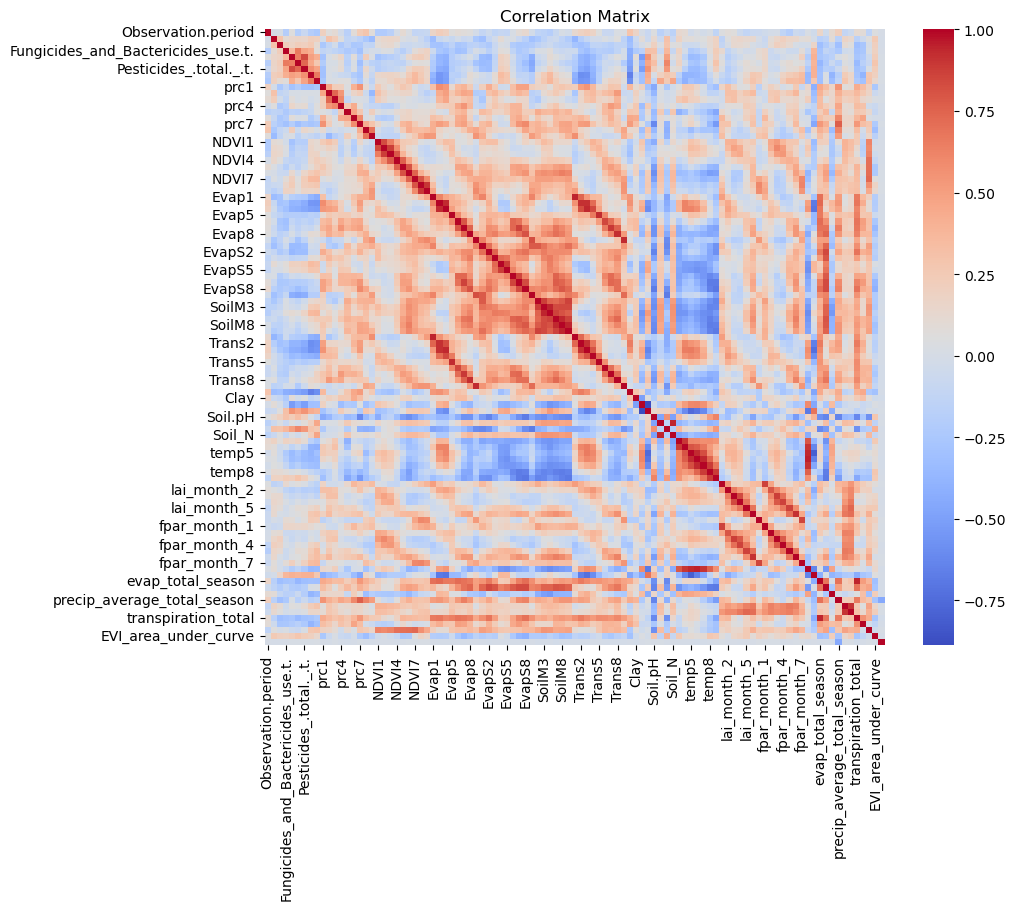

In [10]:
# Select only float columns for correlation
# Select only float columns except the target variable
corr_matrix = uncorrelated_float_cols.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [11]:
def plot_correlation_dendrogram(df, linkage_method='complete'):
    """
    Creates a correlation dendrogram for float columns in a DataFrame.
    Does exactly the same processing as the original code.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    linkage_method : str, default='complete'
        Linkage method for hierarchical clustering ('complete', 'ward', 'average', 'single')
    """
    
    # Keep just the float columns
    float_cols = df.select_dtypes(include=['float64', 'float32'])
    
    # Remove columns with too many NaN values or constant values
    threshold = len(float_cols) * 0.5
    float_cols = float_cols.dropna(axis=1, thresh=threshold)
    float_cols = float_cols.loc[:, float_cols.var() > 0]
    float_cols = float_cols.dropna()
    
    print(f"After cleaning: {float_cols.shape}")
    
    # Compute absolute correlation matrix
    corr_matrix = float_cols.corr().abs()
    corr_matrix = corr_matrix.fillna(0)
    
    # Convert correlation to distance
    distance_matrix = 1 - corr_matrix
    
    # Clip distance values to [0, 1] to avoid negative values due to floating point errors
    distance_matrix = np.clip(distance_matrix, 0, 1)
    
    # Ensure diagonal is exactly zero
    np.fill_diagonal(distance_matrix.values, 0)
    
    # Check the diagonal is now zero
    print(f"Diagonal values: {np.diag(distance_matrix)[:5]}...")  # Show first 5
    
    # Convert to condensed distance matrix
    condensed_distance = squareform(distance_matrix)
    
    # Perform hierarchical clustering
    linked = linkage(condensed_distance, method=linkage_method)
    
    # Plot dendrogram
    plt.figure(figsize=(15, 8))
    dendrogram(linked, 
               labels=distance_matrix.columns, 
               leaf_rotation=90,
               leaf_font_size=8)
    plt.title(f"Dendrogram of Features Based on Correlation ({linkage_method.capitalize()} Linkage)", fontsize=14)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Distance", fontsize=12)
    plt.tight_layout()
    plt.show()

After cleaning: (22707, 98)
Diagonal values: [0. 0. 0. 0. 0.]...


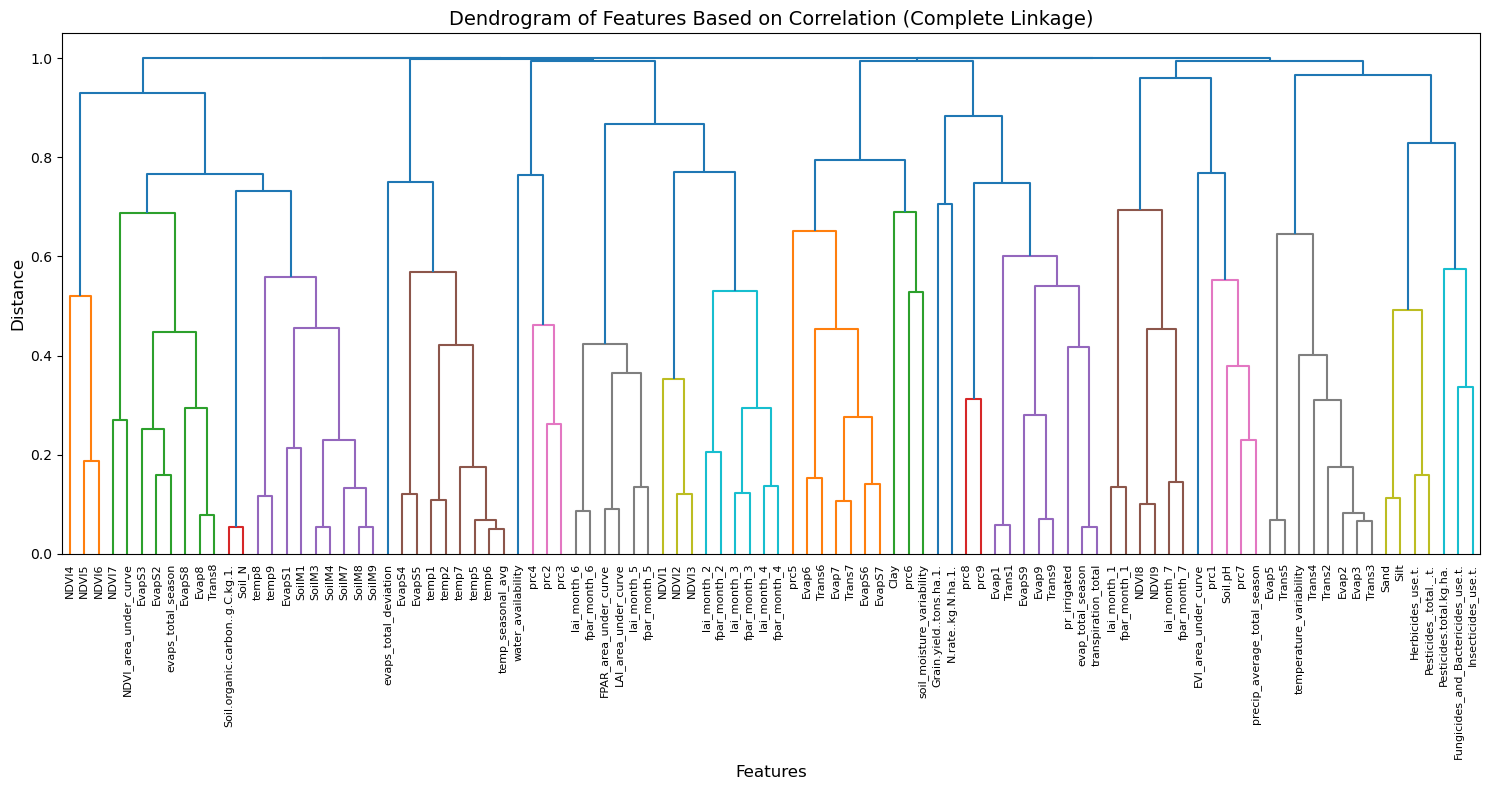

In [12]:
plot_correlation_dendrogram(uncorrelated_float_cols, linkage_method='complete')

In [13]:
Catcols = ['Conversion.for.longitude', 'Conversion.for.latitude',
             "Crop.variety", "Pest.prescence....64", "Treatment_Category", "AEZ"
]

# Combine uncorrelated float columns and categorical columns
selected_cols = list(uncorrelated_float_cols.columns) + [col for col in Catcols if col in df_cleaned.columns]
df_cleaned = df_cleaned[selected_cols]

now categories aren't correlated

### encoding cols and preparing data

check object datatypes 

convert AEZ to object

In [14]:
#see how many labels there are before doing rf: 
df_cleaned.select_dtypes(include="object").nunique().sort_values(ascending=False)


Crop.variety          900
Treatment_Category     14
dtype: int64

define a function that encodes object columns accordingly, above the threshold binary encoding is applied

In [15]:
def encode_features_no_target_split(df, cardinality_threshold=30):
   """
   Auto-encode: >30 unique = binary, ≤30 unique = one-hot
   """
   
   df_encoded = df.copy()
   target_col = "Grain.yield..tons.ha.1."
   
   # Get categorical columns
   categorical_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
   if target_col in categorical_cols:
       categorical_cols.remove(target_col)
   
   # Separate by cardinality
   onehot_cols = []
   binary_cols = []
   
   for col in categorical_cols:
       if df_encoded[col].nunique() <= cardinality_threshold:
           onehot_cols.append(col)
       else:
           binary_cols.append(col)
   
   # Apply encodings
   if onehot_cols:
       df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, drop_first=False)
   
   if binary_cols:
       be = ce.BinaryEncoder(cols=binary_cols)
       df_encoded = be.fit_transform(df_encoded)
   
   # Make numeric (except target)
   for col in df_encoded.columns:
       if col != target_col:
           df_encoded[col] = df_encoded[col].astype(float)
   
   return df_encoded

# Usage:
# 1. Encode FULL dataset (keeps target column)
df_encoded_full = encode_features_no_target_split(df_cleaned, cardinality_threshold=30)

In [16]:
df_encoded_full["AEZ"] = df_encoded_full["AEZ"].astype("category")  # Convert AEZ to category type

In [17]:
functions.summarize_dataframe(df_encoded_full)

| variable                                      | dtype    |   count |   pct_complete |   n_unique |
|-----------------------------------------------|----------|---------|----------------|------------|
| Observation.period                            | float64  |   22709 |            100 |         15 |
| Grain.yield..tons.ha.1.                       | float64  |   22709 |            100 |       9460 |
| N.rate..kg.N.ha.1.                            | float64  |   22709 |            100 |        185 |
| Fungicides_and_Bactericides_use.t.            | float64  |   22709 |            100 |        121 |
| Herbicides_use.t.                             | float64  |   22709 |            100 |        122 |
| Insecticides_use.t.                           | float64  |   22709 |            100 |        123 |
| Pesticides_.total._.t.                        | float64  |   22709 |            100 |        123 |
| Pesticides.total.kg.ha.                       | float64  |   22709 |            100 |    

create a spacially and temporall independent holdout set past 2018 that is pre-encoded 

In [18]:
# Step 1: Create unique lat/lon identifier
df_encoded_full['lat_lon_id'] = df_encoded_full['Conversion.for.latitude'].astype(str) + '_' + df_encoded_full['Conversion.for.longitude'].astype(str)

# Step 2: Identify lat/lon combinations that ONLY have data after 2018
future_only_coords = (
   df_encoded_full.groupby("lat_lon_id")["Observation.period"]
   .min()
   .gt(2018)
)

future_coord_ids = future_only_coords[future_only_coords].index.tolist()
print(f"Number of future-only coordinate combinations: {len(future_coord_ids)}")

# Step 3: Extract future holdout data
future_holdout = df_encoded_full[df_encoded_full["lat_lon_id"].isin(future_coord_ids)]

# Step 4: Create training dataset (remove future-only coordinates)
df_encoded_full = df_encoded_full[~df_encoded_full["lat_lon_id"].isin(future_coord_ids)]

# Step 5: Drop the temporary lat_lon_id column
df_encoded_full = df_encoded_full.drop(columns=["lat_lon_id"])
future_holdout = future_holdout.drop(columns=["lat_lon_id"])

Number of future-only coordinate combinations: 17


/tmp/ipykernel_1505178/1390316218.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_encoded_full['lat_lon_id'] = df_encoded_full['Conversion.for.latitude'].astype(str) + '_' + df_encoded_full['Conversion.for.longitude'].astype(str)


Split target variable for XGboost regression 

In [19]:
# 3. NOW split X and y consistently
X_encoded = df_encoded_full.drop("Grain.yield..tons.ha.1.", axis=1)
y = df_encoded_full["Grain.yield..tons.ha.1."]

X_holdout = future_holdout.drop("Grain.yield..tons.ha.1.", axis=1)  
y_holdout = future_holdout["Grain.yield..tons.ha.1."]

### Agglometric clustering (space only)

The function below performs agglometric clustering in the complete form, with a distance threshold informed by a semi variogram. This way it is able to form spacial clusters of observation rows while minimising spacial autocorrelation

In [182]:
# -------------------------
# Haversine Distance Matrix
# -------------------------
def haversine_distance_matrix(coords_rad):
    lat = coords_rad[:, 0][:, np.newaxis]
    lon = coords_rad[:, 1][:, np.newaxis]

    dlat = lat - lat.T
    dlon = lon - lon.T

    a = np.sin(dlat / 2)**2 + np.cos(lat) * np.cos(lat.T) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Earth's radius in km

# -------------------------
# Spatial Agglomerative Clustering (on unique locations only)
# -------------------------
def agglomerative_spatial(df, lat_col, lon_col, radius_km):
    df = df.copy()

    # 1. Extract and deduplicate valid coordinates 
    coords_df = df[[lat_col, lon_col]].dropna().drop_duplicates().reset_index(drop=False)
    coords_rad = np.radians(coords_df[[lat_col, lon_col]].values)

    # 2. Compute distance matrix and cluster
    dist_matrix = haversine_distance_matrix(coords_rad)
    model = AgglomerativeClustering(
        metric='precomputed',
        linkage='complete',
        distance_threshold=radius_km,
        n_clusters=None
    )
    labels = model.fit_predict(dist_matrix)

    # 3. Assign cluster labels to the unique coordinate rows
    coords_df['spatial_group'] = labels

    # 4. Merge labels back to the original DataFrame
    df = df.merge(coords_df[[lat_col, lon_col, 'spatial_group']], on=[lat_col, lon_col], how='left')

    # 5. Ensure spatial_group is nullable Int
    df['spatial_group'] = df['spatial_group'].astype("Int64")

    return df

In [183]:
X_encoded = agglomerative_spatial(
    X_encoded,
    lat_col='Conversion.for.latitude',
    lon_col='Conversion.for.longitude',
    radius_km=25
)


In [184]:
pd.set_option('display.max_rows', None)

X_encoded['spatial_group'].value_counts()

spatial_group
96     2345
11     2102
91     2000
35     1284
18     1256
162    1000
76     1000
70      989
21      730
6       520
118     517
161     478
149     467
36      449
126     396
59      288
50      194
106     194
52      158
33      158
34      158
86      154
94      152
64      144
121     140
156     136
53      118
45      118
26      118
93      114
128     114
60      114
90      112
63      112
141      96
165      96
49       95
19       91
22       80
57       79
16       76
142      75
154      72
12       68
5        67
78       60
83       60
82       57
151      50
65       48
101      48
102      48
20       48
155      48
2        48
0        47
58       44
148      42
54       42
31       40
38       40
23       40
29       40
44       40
27       40
46       40
13       38
66       36
75       36
30       36
110      36
71       35
119      33
157      33
1        32
7        31
166      30
120      30
4        29
32       28
8        27
88       25
40

#### Dealing with spacial domination in the dataset

A greedy kfold clustering mechanism was implemented, which groups spacial clusters together into 10 neat KFolds for cross validation

In [185]:
def create_balanced_folds(df, spatial_col='spatial_group', n_folds=10):
    """Create balanced fold assignments from dataframe with spatial groups."""
    group_counts = df.groupby(spatial_col).size().reset_index()
    group_counts.columns = [spatial_col, 'count']
    sorted_groups = group_counts.sort_values('count', ascending=False)

    fold_sizes = [0] * n_folds
    group_to_fold = {}

    for _, row in sorted_groups.iterrows():
        min_fold = int(np.argmin(fold_sizes))
        fold_sizes[min_fold] += int(row['count'])
        group_to_fold[row[spatial_col]] = min_fold

    df = df.copy()
    df['fold_group'] = df[spatial_col].map(group_to_fold)

    # progress print
    total_obs = len(df)
    print(f"Total: {total_obs} obs, Target per fold: {total_obs/n_folds:.0f}")
    for i, size in enumerate(fold_sizes):
        print(f"Fold {i + 1}: {size} obs")
    return df

In [186]:
df_with_folds = create_balanced_folds(X_encoded, spatial_col='spatial_group', n_folds=10)

Total: 21699 obs, Target per fold: 2170
Fold 1: 2345 obs
Fold 2: 2149 obs
Fold 3: 2151 obs
Fold 4: 2151 obs
Fold 5: 2150 obs
Fold 6: 2151 obs
Fold 7: 2151 obs
Fold 8: 2151 obs
Fold 9: 2150 obs
Fold 10: 2150 obs


Define Training and testing set (prepare for agony)

In [187]:
# Drop the spatial group column after fold assignment aswell as the latitude and longitude columns
X_encoded.drop(columns=['spatial_group', 'Conversion.for.longitude', 'Conversion.for.latitude'], inplace=True, errors='ignore')  # Remove spatial group column after fold assignment

# --- Align indices (same order for all three) ---
df_with_folds = df_with_folds.reset_index(drop=True)
X_encoded     = X_encoded.reset_index(drop=True)
y             = y.reset_index(drop=True)

assert len(df_with_folds) == len(X_encoded) == len(y)
assert (df_with_folds.index == X_encoded.index).all()
assert (X_encoded.index == y.index).all()

# --- Predefined 10-fold CV from your fold_group (0..9 for every row) ---
from sklearn.model_selection import PredefinedSplit
test_fold_all = df_with_folds['fold_group'].to_numpy()   # length = N
cv = PredefinedSplit(test_fold=test_fold_all)             # creates 10 splits (one per fold id)

# (Optional) quick check: number of splits
print("Unique folds in CV:", len(set(test_fold_all)))


Unique folds in CV: 10


### Attempting to implement recursive feature elimination 

In [ ]:

SEED = 42  # Random seed for reproducibility

# ----- Base RF model (analogous to your xgb_model) -----
rf_model = RandomForestRegressor(
    n_jobs=4,
    random_state=SEED
)

# ----- RF hyperparameter search space (see settings block below) -----
param_dist = {
    "n_estimators": np.arange(100, 1000, 100),
    "max_depth": [None] + list(np.arange(3, 31)),
    "max_features": ['sqrt', 'log2', 0.6, 0.8, 1.0],
    "bootstrap": [True, False],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": np.arange(1, 11),
    "min_impurity_decrease": [0.0, 1e-7, 1e-6, 1e-5, 1e-4],
    "ccp_alpha": np.linspace(0.0, 0.01, 6),
}

# ----- scoring (reuse your dict) -----
scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# ---------- 4) First HPO on full features using your folds ----------
search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring=scoring,
    refit='mae',
    cv=cv,                 # <- same PredefinedSplit you already built
    verbose=1,
    n_jobs=4,
    random_state=SEED
)
search.fit(X_encoded, y)
best_params = search.best_params_
print("Best params (full features):", best_params)

# ---------- 5) RFECV with same folds ----------
rfecv = RFECV(
    estimator=RandomForestRegressor(
        **best_params,
        n_jobs=4,
        random_state=SEED
    ),
    cv=cv,                                  # <- same CV object as XGB
    scoring='neg_mean_absolute_error',
    step=5,
    min_features_to_select=50
)
X_encoded_selected = rfecv.fit_transform(X_encoded, y)
print(f"Features selected: {X_encoded.shape[1]} → {X_encoded_selected.shape[1]}")

# (optional) keep names/indices aligned like in your notebook
selected_features = X_encoded.columns[rfecv.support_]
X_encoded_selected = pd.DataFrame(
    X_encoded_selected,
    columns=selected_features,
    index=X_encoded.index
)

# ---------- 6) Final HPO on selected features ----------
search_final = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring=scoring,
    refit='mae',
    cv=cv,
    verbose=1,
    n_jobs=4,
    random_state=SEED
)
search_final.fit(X_encoded_selected, y)
best_model = search_final.best_estimator_
print("Final best params:", search_final.best_params_)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best params (full features): {'n_estimators': np.int64(100), 'min_samples_split': 2, 'min_samples_leaf': np.int64(4), 'min_impurity_decrease': 1e-07, 'max_features': 'log2', 'max_depth': np.int64(14), 'ccp_alpha': np.float64(0.0), 'bootstrap': True}
Features selected: 125 → 95
Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [142]:
print("Best parameters (initial search):")
print(search.best_params_)

print("\nBest parameters (final search):")
print(search_final.best_params_)

Best parameters (initial search):
{'n_estimators': np.int64(100), 'min_samples_split': 2, 'min_samples_leaf': np.int64(4), 'min_impurity_decrease': 1e-07, 'max_features': 'log2', 'max_depth': np.int64(14), 'ccp_alpha': np.float64(0.0), 'bootstrap': True}

Best parameters (final search):
{'n_estimators': np.int64(600), 'min_samples_split': 2, 'min_samples_leaf': np.int64(10), 'min_impurity_decrease': 1e-07, 'max_features': 'log2', 'max_depth': np.int64(18), 'ccp_alpha': np.float64(0.004), 'bootstrap': False}


In [ ]:
# Boolean mask from RFECV: True for features kept, False for dropped
mask = rfecv.support_

# Get the actual names of the features that were kept
# (take only the columns in X_trainval where mask == True)
selected_features = X_encoded.columns[mask]

# Rebuild the training+validation set as a DataFrame
X_encoded_selected = pd.DataFrame(
    X_encoded_selected,        # <- NumPy array output from rfecv.fit_transform
    columns=selected_features,  # <- reattach the feature names that were kept
    index=X_encoded.index      # <- preserve the original row labels
)

#Drop columns that were not in the fitting process
X_holdout = X_holdout.drop(columns=['Conversion.for.longitude', 'Conversion.for.latitude']
)   
# 3. Rebuild holdout/test set
X_holdout_selected = pd.DataFrame(
    rfecv.transform(X_holdout),       # <- Transform the test data 
    columns=selected_features,
    index=X_holdout.index
)

Save model holdout data for SHAP analysis

In [ ]:
testdata = X_encoded_selected.merge(y, left_index=True, right_index=True, how='left')
holdoutdata = X_holdout_selected.merge(y_holdout, left_index=True, right_index=True, how='left')

In [ ]:
testdata.to_csv("testdataRF.csv", index=False)
holdoutdata.to_csv("holdoutdataRF.csv", index=False)

In [ ]:
joblib.dump(best_model, "outputs_final/RF_spatial_model.pkl")

['outputs_final/RF_spatial_model.pkl']